### Setup
The code in this notebook was plucked straight from the conditional diffusion [notebook](https://github.com/fastai/course22p2/blob/master/nbs/28_diffusion-attn-cond.ipynb) from the Fastai Diffusion [course](https://course.fast.ai/Lessons/part2.html). The only significant changes were made to the `noisify` and `sample` methods.

In [ ]:
import os
from miniai.imports import *

from einops import rearrange
from fastprogress import progress_bar

In [ ]:
torch.set_printoptions(precision=4, linewidth=140, sci_mode=False)
torch.manual_seed(1)
mpl.rcParams["image.cmap"] = "gray_r"
mpl.rcParams["figure.dpi"] = 70

import logging
logging.disable(logging.WARNING)

set_seed(42)
if fc.defaults.cpus>8: fc.defaults.cpus=8

### Create training dataset

In [ ]:
xl,yl = "image", "label"
name = "fashion_mnist"
dsd = load_dataset(name)

labels = dsd["train"].features["label"].names
n_labels = len(labels)

In [ ]:
bs = 256

In [ ]:
def noisify_simple_diffusion(x):
    device = x.device
    n = len(x)
    t = torch.rand(n,).to(x).clamp(0,0.999)
    t_t = t.reshape(-1, 1, 1, 1)
    z = torch.randn(x.shape, device=device)
    xt = ((1-t_t)*z + t_t*x).to(device)
    return (xt, t), x-z
    
def collate_simple_diffusion(b):
    b = default_collate(b)
    (xt,t),eps = noisify_simple_diffusion(b[xl])
    return (xt,t,b[yl]),eps
    
def dl_simple_diffusion(ds): return DataLoader(ds, batch_size=bs, collate_fn=collate_simple_diffusion, num_workers=4)

In [ ]:
@inplace
def transformi(b): b[xl] = [F.pad(TF.to_tensor(o), (2,2,2,2))-0.5 for o in b[xl]]

tds = dsd.with_transform(transformi)
dls = DataLoaders(dl_simple_diffusion(tds["train"]), dl_simple_diffusion(tds["test"]))

dl = dls.train
(xt,t,c),eps = b = next(iter(dl))

### Create unet

In [ ]:
def lin(ni, nf, act=nn.SiLU, norm=None, bias=True):
    layers = nn.Sequential()
    if norm: layers.append(norm(ni))
    if act : layers.append(act())
    layers.append(nn.Linear(ni, nf, bias=bias))
    return layers
    
def saved(m, blk):
    m_ = m.forward

    @wraps(m.forward)
    def _f(*args, **kwargs):
        res = m_(*args, **kwargs)
        blk.saved.append(res)
        return res

    m.forward = _f
    return m

def pre_conv(ni, nf, ks=3, stride=1, act=nn.SiLU, norm=None, bias=True):
    layers = nn.Sequential()
    if norm: layers.append(norm(ni))
    if act : layers.append(act())
    layers.append(nn.Conv2d(ni, nf, stride=stride, kernel_size=ks, padding=ks//2, bias=bias))
    return layers

def upsample(nf): return nn.Sequential(nn.Upsample(scale_factor=2.), nn.Conv2d(nf, nf, 3, padding=1))

def timestep_embedding(tsteps, emb_dim, max_period= 10000):
    exponent = -math.log(max_period) * torch.linspace(0, 1, emb_dim//2, device=tsteps.device)
    emb = tsteps[:,None].float() * exponent.exp()[None,:]
    emb = torch.cat([emb.sin(), emb.cos()], dim=-1)
    return F.pad(emb, (0,1,0,0)) if emb_dim%2==1 else emb
    
class DownBlock(nn.Module):
    def __init__(self, n_emb, ni, nf, add_down=True, num_layers=1, attn_chans=0):
        super().__init__()
        self.resnets = nn.ModuleList([saved(EmbResBlock(n_emb, ni if i==0 else nf, nf, attn_chans=attn_chans), self)
                                      for i in range(num_layers)])
        self.down = saved(nn.Conv2d(nf, nf, 3, stride=2, padding=1), self) if add_down else nn.Identity()

    def forward(self, x, t):
        self.saved = []
        for resnet in self.resnets: x = resnet(x, t)
        x = self.down(x)
        return x

class UpBlock(nn.Module):
    def __init__(self, n_emb, ni, prev_nf, nf, add_up=True, num_layers=2, attn_chans=0):
        super().__init__()
        self.resnets = nn.ModuleList(
            [EmbResBlock(n_emb, (prev_nf if i==0 else nf)+(ni if (i==num_layers-1) else nf), nf, attn_chans=attn_chans)
            for i in range(num_layers)])
        self.up = upsample(nf) if add_up else nn.Identity()

    def forward(self, x, t, ups):
        for resnet in self.resnets: x = resnet(torch.cat([x, ups.pop()], dim=1), t)
        return self.up(x)

class EmbResBlock(nn.Module):
    def __init__(self, n_emb, ni, nf=None, ks=3, act=nn.SiLU, norm=nn.BatchNorm2d, attn_chans=0):
        super().__init__()
        if nf is None: nf = ni
        self.emb_proj = nn.Linear(n_emb, nf*2)
        self.conv1 = pre_conv(ni, nf, ks, act=act, norm=norm)
        self.conv2 = pre_conv(nf, nf, ks, act=act, norm=norm)
        self.idconv = fc.noop if ni==nf else nn.Conv2d(ni, nf, 1)
        self.attn = False
        if attn_chans: self.attn = SelfAttention2D(nf, attn_chans)

    def forward(self, x, t):
        inp = x
        x = self.conv1(x)
        emb = self.emb_proj(F.silu(t))[:, :, None, None]
        scale,shift = torch.chunk(emb, 2, dim=1)
        x = x*(1+scale) + shift
        x = self.conv2(x)
        x = x + self.idconv(inp)
        if self.attn: x = x + self.attn(x)
        return x

In [ ]:
class CondUNetModel(nn.Module):
    def __init__( self, n_classes, in_channels=3, out_channels=3, nfs=(224,448,672,896), num_layers=1):
        super().__init__()
        self.conv_in = nn.Conv2d(in_channels, nfs[0], kernel_size=3, padding=1)
        self.n_temb = nf = nfs[0]
        n_emb = nf*4
        self.cond_emb = nn.Embedding(n_classes, n_emb)
        self.emb_mlp = nn.Sequential(lin(self.n_temb, n_emb, norm=nn.BatchNorm1d),
                                     lin(n_emb, n_emb))
        self.downs = nn.ModuleList()
        for i in range(len(nfs)):
            ni = nf
            nf = nfs[i]
            self.downs.append(DownBlock(n_emb, ni, nf, add_down=i!=len(nfs)-1, num_layers=num_layers))
        self.mid_block = EmbResBlock(n_emb, nfs[-1])

        rev_nfs = list(reversed(nfs))
        nf = rev_nfs[0]
        self.ups = nn.ModuleList()
        for i in range(len(nfs)):
            prev_nf = nf
            nf = rev_nfs[i]
            ni = rev_nfs[min(i+1, len(nfs)-1)]
            self.ups.append(UpBlock(n_emb, ni, prev_nf, nf, add_up=i!=len(nfs)-1, num_layers=num_layers+1))
        self.conv_out = pre_conv(nfs[0], out_channels, act=nn.SiLU, norm=nn.BatchNorm2d, bias=False)

    def forward(self, inp):
        x,t,c = inp
        temb = timestep_embedding(t, self.n_temb)
        cemb = self.cond_emb(c)
        emb = self.emb_mlp(temb) + cemb
        x = self.conv_in(x)
        saved = [x]
        for block in self.downs: x = block(x, emb)
        saved += [p for o in self.downs for p in o.saved]
        x = self.mid_block(x, emb)
        for block in self.ups: x = block(x, emb, saved)
        return self.conv_out(x)

### Train the model

In [ ]:
lr = 5e-3
epochs = 5
opt_func = partial(optim.Adam, eps=1e-5)
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
cbs = [DeviceCB(), MetricsCB(), ProgressCB(plot=True), BatchSchedCB(sched), MixedPrecision()]
model = CondUNetModel(n_labels, in_channels=1, out_channels=1, nfs=(32,64,128,256), num_layers=2)
learn = Learner(model, dls, nn.MSELoss(), lr=lr, cbs=cbs, opt_func=opt_func)

/home/course22p2/miniai/accel.py:33: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  def before_fit(self, learn): self.scaler = torch.cuda.amp.GradScaler()


loss,epoch,train
0.227,0,train
0.132,0,eval
0.103,1,train
0.100,1,eval
0.091,2,train
0.093,2,eval
0.085,3,train
0.085,3,eval
0.082,4,train
0.082,4,eval


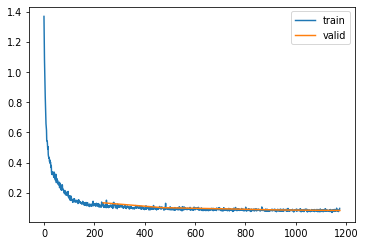

In [10]:
learn.fit(epochs)

### Generate samples

In [11]:
sz = (256,1,32,32)

In [12]:
@torch.no_grad()
def sample(c, model, sz, steps):
    ts = torch.linspace(0,1,steps)
    p = torch.randn(sz).cuda()
    dt = 1.0 / steps
    c = p.new_full((sz[0],), c, dtype=torch.int32)
    preds = []
    for i,t in enumerate(progress_bar(ts)):
        t = t[None].cuda()
        dp_dt = model((p, t, c))
        p += (dp_dt*dt)
        preds.append(p.float().cpu())
    return preds

In [13]:
lbls = dsd["train"].features[yl].names
lbls

['T - shirt / top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

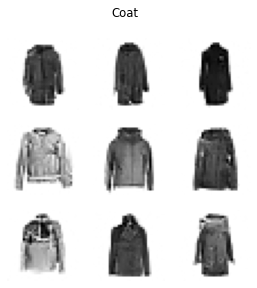

In [19]:
set_seed(42)
cid = 4
preds = sample(cid, model, sz, steps=100)
s = (preds[-1]*2)
show_images(s[:9].clamp(-1,1), imsize=1.5, suptitle=lbls[cid])